In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()

from threedeequadsim import quadsim, controller, trajectory, experiments

In [2]:
test_name = 'hover' # {'hover', 'fig-8'}

In [24]:
nametag = 'final'

In [25]:
folder = './plots/' + time.strftime('%Y-%m-%d') + '/' + nametag + '/'
if not os.path.isdir(folder):
    os.makedirs(folder)
    print('Created data folder ' + folder)

In [26]:
def savefig(plottag):
    plt.savefig(folder + plottag + '.pdf', bbox_inches='tight')
# def savefig(plottag):
#     pass
xyz = ['x', 'y', 'z']

In [6]:
eta_a = 0.0075

eta_A_threshold_convex = 0.0001
eta_A_convex = eta_A_threshold_convex * 1
eta_A_biconvex = 0.0002
eta_A_deep = 0.05

dim_a = 30
dim_A = 150
layer_sizes = (100, 200)

feature_freq = 0.25

In [7]:
q_kwargs = {
    'Vwind' : np.array((0.0, 0, 0)),            # mean wind speed
    'wind_model': 'iid-uniform',                # {'iid', 'random-walk'}
    # 'Vwind_cov' : 7.5,                        # how quickly the wind changes
    # 'wind_constraint' : 'hard',               # 'hard' wind constraint limits wind speed to be within Vwind_gust of the mean speed
    'Vwind_gust' : np.array((5.0, 0., 2.5)),    # for hard wind constrant, wind speed is in the range Vwind +/- Vwind_gust
    'wind_update_period' : 2.0,                 # seconds between wind speed changes
    't_stop' : 30.,
}

In [8]:
CTRLS = [
    controller.Baseline(integral_control=False),
    controller.MetaAdaptBaseline(eta_a_base=eta_a, dim_a=dim_a, dim_A=dim_A, feature_freq=feature_freq, A_type='random'),
    controller.MetaAdaptConvex(eta_a_base=eta_a, eta_A_base=eta_A_convex, eta_A_threshold=eta_A_threshold_convex, dim_a=dim_a, dim_A=dim_A, feature_freq=feature_freq),
    controller.MetaAdaptBiconvex(eta_a_base=eta_a, eta_A_base=eta_A_biconvex, dim_a=dim_a, dim_A=dim_A, feature_freq=feature_freq),
    controller.MetaAdaptDeep(eta_a_base=eta_a, eta_A_base=eta_A_deep, dim_a=dim_a, layer_sizes=layer_sizes),
    controller.Omniscient()
]

Initializing baseline-omac with dim_a=30, dim_A=150
Initializing convex-omac with dim_a=30, dim_A=150
Initializing biconvex-omac with dim_a=30, dim_A=150
Initializing deep-omac with dim_a=30, layer_sizes=(100, 200)


In [9]:
if test_name == 'hover':
    T = trajectory.hover

    t_kwargs = {
        'pd' : np.zeros(3)
    }

elif test_name == 'fig-8':
    T = trajectory.fig8
    t_kwargs = {
        'T': np.pi * 1.5
    }

In [10]:
Data = []
seed = np.random.randint(np.iinfo(np.uint).max, dtype=np.uint)
seed = 120
print(seed)
for c in CTRLS:
    q = quadsim.QuadrotorWithSideForce(**q_kwargs, )    # create a quadrotor object
    t = T(**t_kwargs)                                   # create a trajectory object and initialize the trajectory

    data = q.run(trajectory=t, controller=c, seed=seed)  # run the simulation
                                                        # note: this will set the seed, call c.reset_controller(), then reset the seed again
    Data.append(data)                                   # save the results

120


3001it [00:38, 77.25it/s]                            


(150, 30)


3001it [00:39, 76.24it/s]                            
3001it [00:39, 76.65it/s]                            
3001it [00:40, 73.20it/s]                            
3001it [00:53, 56.04it/s]                            
3001it [00:36, 82.01it/s]                            


In [11]:
print('%15s, %6s, %15s' % ('Controller', 'ACE', 'Steady State ACE'))

err = []
err_ss = []
for i, (c, data) in enumerate(zip(CTRLS, Data)):
    err.append(experiments.get_error(data['X'], data['pd']))
    err_ss.append(experiments.get_error(data['X'], data['pd'], istart=1000)) # ss=steady state
    print('%15s, %5.4f, %5.4f' % (c._name, err[-1]['meanerr'], err_ss[-1]['meanerr']))

     Controller,    ACE, Steady State ACE
            pid, 0.2991, 0.2819
  baseline-omac, 0.1986, 0.1748
    convex-omac, 0.1252, 0.1034
  biconvex-omac, 0.0744, 0.0494
      deep-omac, 0.0662, 0.0386
     omniscient, 0.0330, 0.0300


In [12]:
color = ((1,0,0), (0,1,0), (0,0,1)) # colors for x, y and z directions

baseline-omac
0 0
convex-omac
0 1
biconvex-omac
0 2
deep-omac
0 3


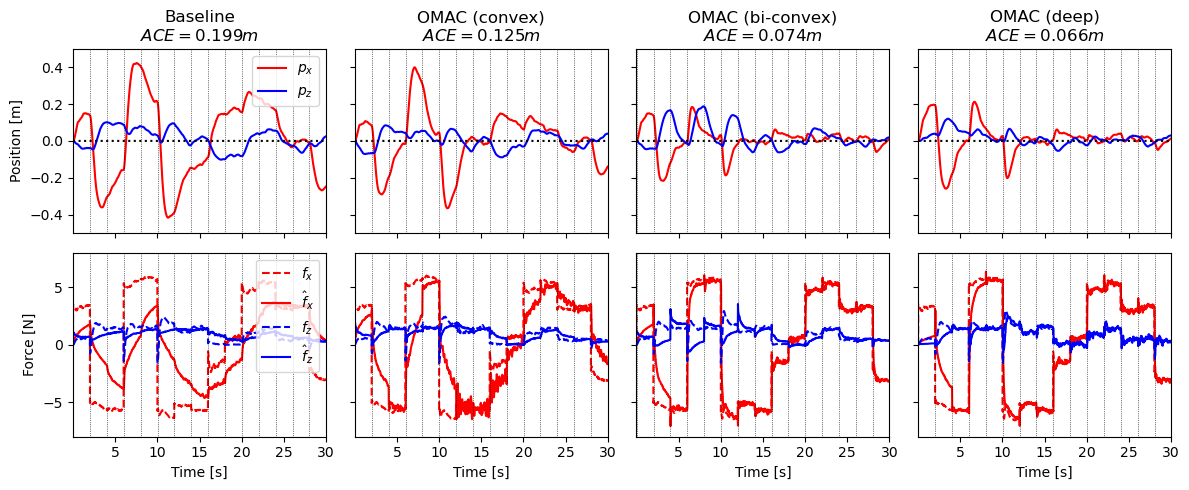

In [31]:
fig = plt.figure(figsize=(12, 5))
# gs = fig.add_gridspec(2,2)
rows = 1
cols = 4 # int(len(Data)/rows)
gs = plt.GridSpec(2 * rows, cols)
for j, data in enumerate(Data):
    if CTRLS[j]._name in ('pid', 'omniscient'):
        continue
    
    print(CTRLS[j]._name)

    row = 0
    col = j - 1

    # Plot position tracking
    ax = fig.add_subplot(gs[row*2, col])
    for i in [0, 2]: # only plot x and z
        plt.plot(data['t'], data['X'][:,i], label=r'$p_' + xyz[i] + '$', color = color[i])
    # Plot vertical lines for each environment switch
    for t in data['t'][data['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)

    plt.margins(x=0)

    if j == 1: # len(Data) - 2:
        plt.legend(loc = 'upper right')
    plt.plot(data['t'], data['pd'][:,i], 'k:',)
    ax.axes.xaxis.set_ticklabels([])
    if col == 0:
        plt.ylabel('Position [m]')
    else:
        ax.axes.yaxis.set_ticklabels([])
    plt.ylim((-0.5, 0.5))
    plt.title(CTRLS[j].name_long + '\n$ACE=%.3f m$' % (err[j]['meanerr'], ))

    # Plot force estimation
    ax = fig.add_subplot(gs[row*2+1, col])
    for i in [0, 2]:
        plt.plot(data['t'], data['Fs'][:,i], '--', label=r'$f_' + xyz[i] + '$', color = color[i])
        if CTRLS[j]._name == 'baseline':
            plt.plot(data['t'], -data['i_term'][:,i], '-', label=r'$K_i\int\tilde{p}_' + xyz[i] + 'dt$', color = color[i])
        else:
            plt.plot(data['t'], data['f_hat'][:,0,i], '-', label=r'$\hat{f}_' + xyz[i] + '$', color = color[i])
    # Plot vertical lines for environment changes
    for t in data['t'][data['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)
    
    plt.margins(x=0)

    if j == 1 : # len(Data) - 2:
        plt.legend(loc = 'upper right')
    if row == rows-1:
        plt.xlabel('Time [s]')
    else: 
        ax.axes.xaxis.set_ticklabels([])
    if col == 0:
        plt.ylabel('Force [N]')
    else:
        ax.axes.yaxis.set_ticklabels([])
    plt.ylim((-8,8))

plt.tight_layout()
savefig('performance_combined')